# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and likelihood estimation.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [56]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [58]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [59]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [60]:
# Import libraries and set JAX backend
import os
# os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [61]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example_v3"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [62]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [63]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

train_iter = iter(train_dataset_grain)

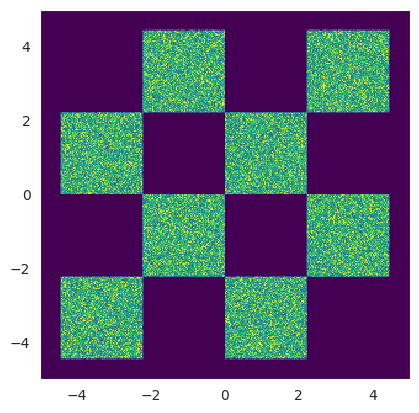

In [64]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [65]:
# Import flow matching components and utilities
from gensbi.flow_matching.path.scheduler import CondOTScheduler
from gensbi.flow_matching.path import AffineProbPath
from gensbi.flow_matching.solver import ODESolver
from gensbi.utils.model_wrapping import ModelWrapper
from gensbi.flow_matching.loss import ContinuousFMLoss

In [66]:
from gensbi.models.flux1joint import  Flux1JointParams, Flux1Joint, Flux1JointCFMLoss

In [67]:
params = Flux1JointParams(
            in_channels=1,
            vec_in_dim=None,
            mlp_ratio=3.0,
            num_heads=2,
            depth_single_blocks=8,
            axes_dim=[2],
            condition_dim=[2],
            qkv_bias=True,
            rngs=nnx.Rngs(0),
            joint_dim=2,
            theta=30,
            guidance_embed=False,
            param_dtype=jnp.float32,
        )

vf_model = Flux1Joint(params)

In [68]:
# @markdown Define optimizer and learning rate schedule parameters
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Relative tolerance for measuring the new optimum:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
RTOL = 1e-4  # @param{type:"number"}
# @markdown learnign rate
MAX_LR = 1e-3  # @param{type:"number"}
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR

In [69]:
# Set up optimizer with reduce-on-plateau schedule
nsteps = 50_000

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    # optax.adamw(warmup_schedule),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)

optimizer = nnx.Optimizer(vf_model, opt, wrt=nnx.Param)

In [70]:
# Restore the model from checkpoint if requested
# if restore_model:
#     checkpointer = ocp.StandardCheckpointer()
#     state = nnx.state(vf_model)


#     state = checkpointer.restore(checkpoint_dir + '/v1', target=state)
#     # update the model with the loaded state
#     nnx.update(vf_model, state)
#     checkpointer.close()
#     print("Model restored from checkpoint.")

## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [71]:
from numpyro import distributions as dist

# define the prior distribution, in this case a 2D gaussian with zero mean and unit variance, 
# but it could be any desired distribution, as long as it is compatible with the data dimension
p0 = dist.Independent(dist.Normal(jnp.zeros(2), jnp.ones(2)), 1)

# for example, we could also define a p0 as a 2D gaussian mixture, in case it made more sense as a prior
# in general though, a gaussian distribution is a good choice as a prior for flow matching

# p0 = dist.MixtureGeneral(
#     mixing_distribution=dist.Categorical(probs=jnp.array([0.5,0.5])),
#     component_distributions=[dist.Independent(
#         dist.Normal(
#             loc=jnp.array([-2.0, -2.0]),
#             scale=jnp.array([0.5, 0.5])
#         ), 1
#     ),
#     dist.Independent(
#         dist.Normal(
#             loc=jnp.array([2.0, 2.0]),
#             scale=jnp.array([0.5, 0.5])
#         ), 1
#     )]
# )

In [72]:
from einops import repeat

In [73]:
# Instantiate the affine path and loss function
path = AffineProbPath(scheduler=CondOTScheduler())

loss_fn_ = Flux1JointCFMLoss(path)

def loss_fn(
            model,
            x_1,
            key: jax.random.PRNGKey,
        ):
            batch_size = x_1.shape[0]
            rng_x0, rng_t, rng_condition = jax.random.split(key, 3)
            # x_0 = p0.sample(rng_x0, (batch_size,))
            x_0 = jax.random.normal(rng_x0, (batch_size, 2,1))
            t = jax.random.uniform(rng_t, x_1.shape[0])
            batch = (x_0, x_1, t)

            loss = loss_fn_(
                model,
                batch,
                node_ids=node_ids,
                condition_mask=condition_mask,
            )
            return loss

node_ids = jnp.arange(2).reshape(1,-1,1)
condition_mask = jnp.zeros((512, 2,1))

@nnx.jit
def train_step(vf_model, optimizer, x_1, key):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(vf_model, x_1, key)
    optimizer.update(vf_model, grads, value=loss)  # In-place updates.

    return loss

In [74]:
# Generate validation data
val_data = make_boxes_jax(jax.random.PRNGKey(1), 512)[...,None]

In [75]:
# Validation loss computation
@nnx.jit
def val_loss(model, key):
    # subkey2, subkey3 = jax.random.split(key, 2)
    x_1 = val_data

    return loss_fn(model, x_1, key)

In [76]:
# Import tqdm for progress bars and set early stopping flag
from tqdm import tqdm
early_stopping = True

In [77]:
# Initialize training state and tracking variables
best_state = nnx.state(vf_model)
best_val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

rngs = nnx.Rngs(42)

The core part of a train step looks like this: 

```python
...
# Generate a batch of target data x_1 from the data generator
x_1 = next(train_iter)
# Sample x_0 from the standard normal prior, matching the shape of x_1
x_0 = p0.sample(rngs.train_step(), (x_1.shape[0],))
# Sample t uniformly in [0, 1] for each data point in the batch
t = jax.random.uniform(rngs.train_step(), x_1.shape[0])

# Prepare the batch tuple for the loss function
batch = (x_0, x_1, t)

train_step(vf_model, optimizer, batch)  # run the training step
...
```

We will now implement this in a context of a full training loop, with validation and early stopping.

In [78]:
# Main training loop (runs only if train_model=True)

# for each epoch, updated the model and then validate
# if the loss function stops improving, stop the training and restore the best model found so far

nsteps=10_000


if train_model:
    vf_model.train()


    pbar = tqdm(range(nsteps))
    l = 0
    v_l = 0
    for j in pbar:
        if counter > cmax and early_stopping:
            print("Early stopping")
            # restore the model state to the best found so far
            graphdef, abstract_state = nnx.split(vf_model)

            vf_model = nnx.merge(graphdef, best_state)
            break

        # Generate a batch of target data x_1 from the data generator
        x_1 = next(train_iter)

        # Compute loss and update model parameters in-place
        loss = train_step(vf_model, optimizer, x_1, rngs.train_step())  # update model parameters
        l += loss.item()

        # Compute validation loss for early stopping and LR scheduling
        v_loss = val_loss(vf_model, rngs.val_step())
        v_l += v_loss.item()

        if j > 0 and j % 100 == 0:
            # Compute average training and validation loss over the last 100 steps
            loss_ = l / 100
            val_ = v_l / 100

            # Compute ratios for early stopping and best model tracking
            ratio1 = val_ / loss_
            ratio2 = val_ / best_val_loss_value

            # If validation loss is not diverging, update best state if needed
            if ratio1 < val_error_ratio:
                if val_ < best_val_loss_value:
                    best_val_loss_value = val_
                    best_state = nnx.state(vf_model)
                elif ratio2 < 1.05:
                    best_state = nnx.state(vf_model) # still update the best state if the ratio is below 1.05

                counter = 0
            else:
                # If validation loss is diverging, increment early stopping counter
                counter += 1

            # Update progress bar with current metrics
            pbar.set_postfix(
                loss=f"{loss_:.4f}",
                ratio=f"{ratio1:.4f}",
                counter=counter,
                val_loss=f"{val_:.4f}",
            )
            loss_array.append(loss_)
            val_loss_array.append(val_)
            l = 0
            v_l = 0

    vf_model.eval()



  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [08:11<00:00, 20.36it/s, counter=0, loss=3.7764, ratio=1.0012, val_loss=3.7808]


In [79]:
# Save the trained model to checkpoint (if training was performed)
if train_model:
    checkpointer = ocp.StandardCheckpointer()
    model_state = nnx.state(vf_model)
    checkpointer.save(checkpoint_dir + '/v1.1', model_state)
    checkpointer.close()

ValueError: Destination /lustre/ific.uv.es/ml/ific088/github/GenSBI-examples/examples/checkpoints/flow_matching_2d_example_v3/v1.1 already exists.

## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [80]:
# Set model to evaluation mode before sampling
vf_model.eval()

class SimpleWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, t, obs, *args, **kwargs):
        obs = self._expand_dims(obs)
        # t = self._expand_time(t)

        return self.model(obs=obs, t=t, node_ids=node_ids, condition_mask=jnp.zeros((1,2,1)))

In [81]:
# Wrap the model for ODE solver compatibility
vf_wrapped = SimpleWrapper(vf_model)

In [ ]:
# Sample trajectories from the model using ODE solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 500_000  # batch size
T = jnp.linspace(0,1,10)  # sample times

# x_init = pipeline.p0_dist_model.sample(jax.random.PRNGKey(0), (batch_size, ))  # initial conditions
x_init = jax.random.normal(jax.random.PRNGKey(0), (batch_size, 2))
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

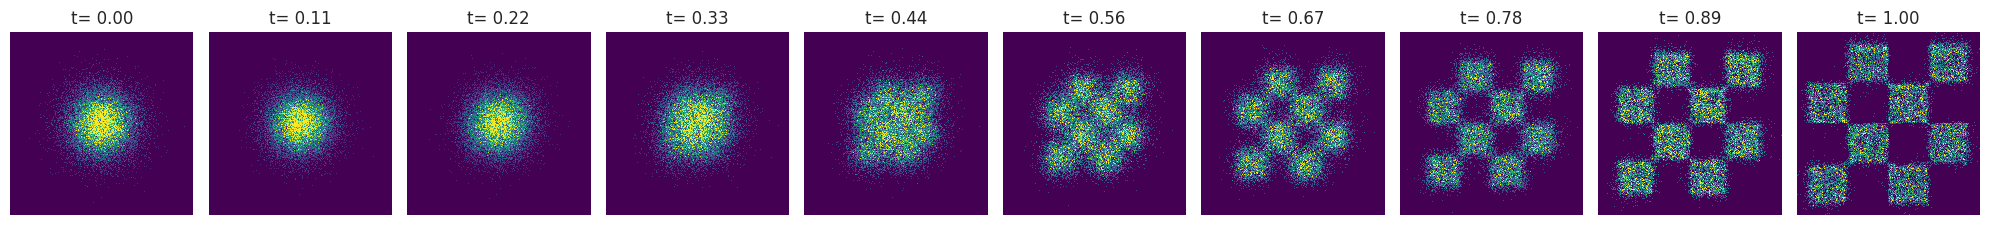

In [83]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [84]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

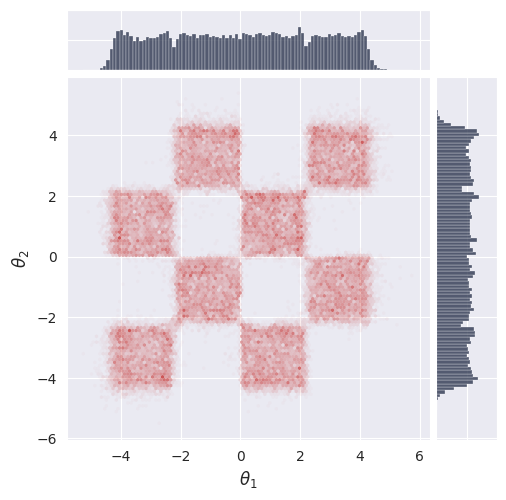

In [85]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [86]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

x_init = p0.sample(jax.random.PRNGKey(0), (batch_size, ))  # initial conditions
solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='Dopri5', step_size=step_size, return_intermediates=True)

In [87]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

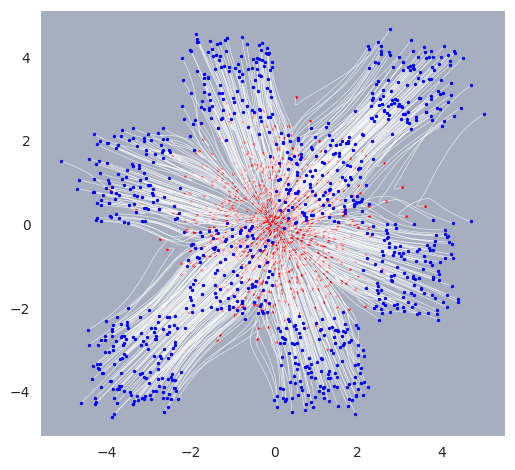

In [88]:
# Plot sampled trajectories
fig, ax = plot_trajectories(sol)
plt.grid(False)
plt.show()

## 7. Likelihood Estimation

This section demonstrates how to estimate and visualize the likelihood of the model on a grid of points in 2D space.

### sample the likelihood

In [89]:
# Import numpyro distributions for likelihood computation
import numpyro.distributions as dist

In [90]:
# Prepare grid for likelihood evaluation
T = jnp.array([1., 0.])  # sample times
grid_size = 200
x_1 = jnp.meshgrid(jnp.linspace(-5, 5, grid_size), jnp.linspace(-5, 5, grid_size))
x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

In [91]:
# log_prob of the prior distribution
# Note: p0 is defined as an isotropic Gaussian with zero mean and unit variance
gaussian_log_density = p0.log_prob

In [ ]:
# Compute unnormalized log-likelihood using the ODE solver
sampler = solver.get_unnormalized_logprob(time_grid=[1.0,0.0], method='Dopri5', step_size=step_size, log_p0=gaussian_log_density)

exact_log_p = sampler(x_1)

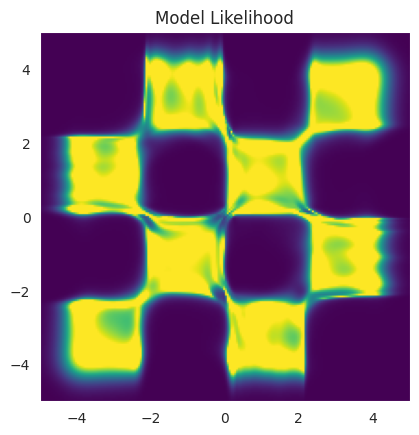

In [ ]:
# Visualize the model likelihood on the 2D grid
likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

cmin = 0
cmax = 1/40.5 # the domain goes from -4.5 to 4.5. The total area is (4.5*2)**2. Since only half of the area is covered by the data likelihood, we divide by 2 -> (4.5*2)**2 / 2 = 40.5. As Such 1/40.5 is the max theoretical likelihood value
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

# Create the figure and axis objects explicitly
fig, ax = plt.subplots()

likelihood = np.array(jnp.exp(exact_log_p[-1,:]).reshape(grid_size, grid_size))

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

im = ax.imshow(likelihood, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis', norm=norm)
ax.set_title('Model Likelihood')

plt.grid(False)
plt.show()